In [27]:
import pandas as pd
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim

In [3]:
dat = pd.read_csv('brunch_process.csv')
reviews=dat["text"].tolist()
stars=dat["stars"].tolist()
dat.shape

(505696, 2)

We collect some nuetral words which we can't tell what it refers to or indicates as no_importance_words. Then construct a dictionary without no_importance_words.

In [4]:
no_importance_words=["food","make","come","take","give","dish","didnt","love","best","ask",
                     "find","definitely","little","more","menu","que","les","bon","se",
                     "et_le","un_peu","tr\xe8s"]
rev=[]
for text in reviews:
    if type(text)==float:#in case there's nan
        rev.append([])
        continue
    a=text.split(" ")
    if (set(a) & set(no_importance_words)):
        retain=[]
        for i in a:
            if i not in no_importance_words:
                retain.append(i)
        rev.append(retain)
    else:
        rev.append(a)
len(rev)

505696

In [5]:
[] in rev

True

In [6]:
del_index=[]
for i in range(len(rev)):
    if len(rev[i])==0:
        del_index.append(i)
del_index.reverse()
for i in del_index:
    del reviews[i]
    del stars[i]
    del rev[i]

In [9]:
len(rev)

505685

In [10]:
dic=gensim.corpora.Dictionary(rev)
len(dic.keys())

218635

The structure of dictionary is like below. The keys of dictionary are unique word ids and the values are the corresponding words. What's more, the words in vocabulary can't be either too common or too rare.

In [11]:
count=0
for k, v in dic.iteritems():
    print(k, v)   #k is assigned by the sequence of alphabet
    count+=1
    if count > 10:
        break

(175331, u'not_baretta')
(53296, u'spend_afternoon')
(188946, u'woode')
(107890, u'mainly_consist')
(58086, u'facebook_post')
(123673, u'not_service_not_outstanding')
(80235, u'woods')
(174865, u'focaccica')
(21966, u'woody')
(45922, u'comically')
(201246, u'spidery')


In [12]:
dic.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
#no_below: absolute number, no_above: fraction
len(dic.keys())

53955

Then we compute the tfidf scores for each word based on their frequency.

In [13]:
word_times = [dic.doc2bow(text) for text in rev] #frequency
tfidf = models.TfidfModel(word_times)
tfidf_scores = tfidf[word_times]

Taking the 10000th review as an example, we can see how word_times is like.

In [15]:
sample_10000 = word_times[10000]
reviews[10000]

'definitely unique_twist enchilada start spicey potato corn_chowder doc guajillo short_rib little jack_cheddar nice ceramic dish surprise put little oven finish soup bam deliciouso wife split enchilada dish corn_flour tortilla straight corn roast_tomatillo chicken other sweet spicey cornbread again doc otg delicious sauce red_green few more goody back oven awesomeness flavor little back_again'

In [16]:
for i in range(len(sample_10000)):
    print("Word {} (\"{}\") appears {} time.".format(sample_10000[i][0], dic[sample_10000[i][0]], sample_10000[i][1]))

Word 30 ("flavor") appears 1 time.
Word 67 ("again") appears 1 time.
Word 69 ("delicious") appears 1 time.
Word 101 ("finish") appears 1 time.
Word 118 ("nice") appears 1 time.
Word 133 ("put") appears 1 time.
Word 137 ("sauce") appears 1 time.
Word 201 ("wife") appears 1 time.
Word 264 ("few") appears 1 time.
Word 297 ("other") appears 1 time.
Word 299 ("start") appears 1 time.
Word 352 ("surprise") appears 1 time.
Word 359 ("chicken") appears 1 time.
Word 441 ("back") appears 1 time.
Word 757 ("tortilla") appears 1 time.
Word 764 ("potato") appears 1 time.
Word 788 ("split") appears 1 time.
Word 957 ("sweet") appears 1 time.
Word 1475 ("back_again") appears 1 time.
Word 1701 ("straight") appears 1 time.
Word 1847 ("corn") appears 1 time.
Word 2582 ("enchilada") appears 2 time.
Word 2603 ("soup") appears 1 time.
Word 3459 ("awesomeness") appears 1 time.
Word 3995 ("short_rib") appears 1 time.
Word 4085 ("doc") appears 2 time.
Word 4379 ("goody") appears 1 time.
Word 4547 ("oven") appe

Then we construct Latent Dirichlet Allocation(LDA) model based on the tfidf score we calculated above. LDA model is a “generative probabilistic model” of a collection of composites made up of parts. It will finally give us two matrices, one is probabilities of parts given a specific topic, the other is probabilities of topics given a composite. Here composites refer to reviews and parts refer to words or phrases. And we use coherence score as the criteria to decide how many topics are best fitted.

In [18]:
coh_score=[]
for i in [10,15,18,20,25,30,50]:
    lda_tfidf= gensim.models.LdaMulticore(tfidf_scores, num_topics=i, id2word=dic, passes=2, workers=3)
    coherence_model = gensim.models.CoherenceModel(model=lda_tfidf, texts=rev, dictionary=dic, coherence='c_v')
    coh_score.append(coherence_model.get_coherence())

/anaconda2/lib/python2.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/anaconda2/lib/python2.7/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


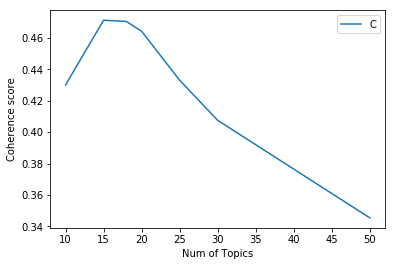

In [24]:
x=[10,15,18,20,25,30,50]
coh_score=[0.4299810280974564,0.471131401488,0.4703701288910809,0.464106444133,0.4329478473167171,0.407451572041,0.345406093358]
plt.plot(x, coh_score)
plt.xlabel("Num of Topics")
plt.ylabel("Coherence score")
plt.legend(("C"), loc='best')
plt.show()

The 15-topics lda model, with the highest coherence score will be kept for later use. And all of the 15 topics are like below, in the form of sum of weight times word. And we can summarise the keywords in each topic to a more general one with the help of synonym and similarity generated by Word2Vec model.

In [25]:
lda_tfidf_15=gensim.models.LdaMulticore(tfidf_scores, num_topics=15, id2word=dic, passes=2, workers=3)
for idx, topic in lda_tfidf_15.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.007*"beer" + 0.006*"happy_hour" + 0.005*"bar" + 0.005*"drink" + 0.004*"nice" + 0.004*"patio" + 0.004*"atmosphere" + 0.004*"service" + 0.004*"bruschetta" + 0.004*"awesome"
Topic: 1 
Word: 0.008*"egg" + 0.008*"pancake" + 0.006*"waffle" + 0.006*"bacon" + 0.006*"potato" + 0.005*"delicious" + 0.005*"french_toast" + 0.005*"service" + 0.004*"chicken" + 0.004*"side"
Topic: 2 
Word: 0.002*"coffee" + 0.002*"time" + 0.002*"sandwich" + 0.002*"burger" + 0.002*"taste" + 0.002*"nice" + 0.002*"want" + 0.002*"back" + 0.002*"only" + 0.002*"table"
Topic: 3 
Word: 0.003*"healthy_option" + 0.003*"service" + 0.002*"bob_evans" + 0.002*"nice" + 0.002*"devil_egg" + 0.002*"short_stack" + 0.002*"philly_cheese" + 0.002*"west_side" + 0.002*"coffee" + 0.002*"pint"
Topic: 4 
Word: 0.011*"coffee" + 0.006*"delicious" + 0.006*"sandwich" + 0.005*"nice" + 0.005*"bagel" + 0.005*"service" + 0.005*"friendly" + 0.005*"lunch" + 0.004*"spot" + 0.004*"fresh"
Topic: 5 
Word: 0.006*"bruschetta_board" + 0.004*"gy

Then we use pyLDAvis package to visualize the produced topics and associated keywords.

In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_tfidf_15, tfidf_scores, dic)
vis

/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
14     17.080112        1       1  0.160111  0.044690
12     14.289848        1       2  0.165975  0.077673
1      11.654373        1       3  0.178687 -0.018137
2      10.631954        1       4  0.144620  0.031257
4       9.480907        1       5  0.178831 -0.066604
11      8.742539        1       6  0.170545 -0.087507
0       7.222924        1       7  0.141953 -0.035612
13      3.562421        1       8 -0.066332  0.185231
3       3.111765        1       9  0.014216 -0.001107
7       3.047225        1      10 -0.029689  0.034514
6       2.400091        1      11 -0.265209  0.253360
5       2.310822        1      12 -0.195122 -0.059748
9       2.299526        1      13 -0.110276 -0.102689
8       2.267531        1      14 -0.172503 -0.087441
10      1.897955        1      15 -0.315807 -0.167879, topic_info=      Category         Freq                   Term        Total  loglift  \
term                                                                       
19030  Default  2832.000000                  donut  2832.000000  30.0000   
12429  Default  2431.000000                   taco  2431.000000  29.0000   
35871  Default   948.000000          banana_muffin   948.000000  28.0000   
45871  Default  1410.000000                burrito  1410.000000  27.0000   
9928   Default  1167.000000                  salsa  1167.000000  26.0000   
3488   Default  6042.000000                 coffee  6042.000000  25.0000   
36550  Default  2191.000000                   beer  2191.000000  24.0000   
46128  Default   584.000000                 cartel   584.000000  23.0000   
30113  Default  6652.000000              delicious  6652.000000  22.0000   
32432  Default  1566.000000             happy_hour  1566.000000  21.0000   
45426  Default  4326.000000                    egg  4326.000000  20.0000   
19531  Default   678.000000            carne_asada   678.000000  19.0000   
17437  Default  2357.000000                  crepe  2357.000000  18.0000   
5754   Default  4015.000000                pancake  4015.000000  17.0000   
53443  Default  1736.000000                  bagel  1736.000000  16.0000   
47816  Default  4486.000000                  amaze  4486.000000  15.0000   
9866   Default  4488.000000              excellent  4488.000000  14.0000   
27348  Default  4555.000000                awesome  4555.000000  13.0000   
36904  Default  3020.000000                 waffle  3020.000000  12.0000   
9629   Default   854.000000           mexican_food   854.000000  11.0000   
43135  Default  4062.000000             atmosphere  4062.000000  10.0000   
309    Default  8792.000000                service  8792.000000   9.0000   
13189  Default   962.000000             banana_nut   962.000000   8.0000   
5692   Default  4664.000000               friendly  4664.000000   7.0000   
49967  Default   933.000000                   bean   933.000000   6.0000   
6657   Default  3351.000000                amazing  3351.000000   5.0000   
45160  Default  2863.000000                 potato  2863.000000   4.0000   
34391  Default  2497.000000       highly_recommend  2497.000000   3.0000   
40191  Default  2917.000000                  bacon  2917.000000   2.0000   
32524  Default  2535.000000              wonderful  2535.000000   1.0000   
...        ...          ...                    ...          ...      ...   
41414  Topic15    74.579582                   slop    75.760010   3.9487   
42014  Topic15    74.536682                  rowdy    75.717102   3.9487   
49751  Topic15    84.811829                    dan    86.177391   3.9484   
35871  Topic15   900.333679          banana_muffin   948.334045   3.9125   
10229  Topic15   124.916245       authentic_french   129.546570   3.9280   
52398  Topic15   179.379913                 nicole   194.310349   3.8844   
12371  Topic15   106.312592        fun_environment   110.962425   3.9216   

For sample_10000, the topics match it best are as below. Each topic has a score with repect to the correlation with the review and these scores sum up to 1.

In [30]:
for index, score in sorted(lda_tfidf_15[sample_10000], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_tfidf_15.print_topic(index, 15)))


Score: 0.348335146904	 
Topic: 0.008*"egg" + 0.008*"pancake" + 0.006*"waffle" + 0.006*"bacon" + 0.006*"potato" + 0.005*"delicious" + 0.005*"french_toast" + 0.005*"service" + 0.004*"chicken" + 0.004*"side" + 0.004*"muffin" + 0.004*"omelette" + 0.004*"toast" + 0.004*"biscuit" + 0.004*"hash"

Score: 0.205668836832	 
Topic: 0.018*"taco" + 0.010*"burrito" + 0.009*"salsa" + 0.007*"carne_asada" + 0.005*"mexican_food" + 0.004*"chip_salsa" + 0.004*"bean" + 0.004*"guacamole" + 0.004*"tortilla" + 0.004*"fish_taco" + 0.004*"rice_bean" + 0.004*"chip" + 0.003*"horchata" + 0.003*"cheese_curd" + 0.003*"mexican"

Score: 0.163219988346	 
Topic: 0.003*"buffet" + 0.003*"taste" + 0.003*"salad" + 0.003*"price" + 0.003*"dessert" + 0.002*"burger" + 0.002*"only" + 0.002*"pretty" + 0.002*"dinner" + 0.002*"time" + 0.002*"nice" + 0.002*"other" + 0.002*"fry" + 0.002*"service" + 0.002*"chicken"

Score: 0.105343133211	 
Topic: 0.002*"est" + 0.002*"lake" + 0.002*"not_place" + 0.002*"ahwatukee" + 0.002*"never_not_com

We also define two functions as the tools. One is select and gather words in topic with weight larger than 0.002, the other is to calculate the times of appearance of each topic in reviews with different stars.

In [31]:
def gather_topic(topicnum,ldamodel,w2vmodel):
    main=[]
    for i in range(0,topicnum):
        terms=[]
        j=0
        while (ldamodel.get_topic_terms(i,100)[j][1] >= 0.002) and (j<=98):
            wordid=ldamodel.get_topic_terms(i,100)[j][0]
            terms.append(str(dic[wordid]))
            j+=1
        #if len(terms) != 0:
            #terms=terms + above_70(w2vmodel,terms)
        main.append(terms)
    return main

def count_topic(topicnum,ldamodel,stars):
    scores=[[]]*topicnum
    for i in range(len(scores)):
        scores[i]=scores[i]+[0,0,0,0,0]
    n1=0;n2=0;n3=0;n4=0;n5=0;
    for i in range(len(reviews)):   
        if stars[i]==1:
            n1+=1
            for topicid, score in ldamodel[word_times[i]]:
                scores[topicid][0]+=score
        if stars[i]==2:
            n2+=1
            for topicid, score in ldamodel[word_times[i]]:
                scores[topicid][1]+=score
        if stars[i]==3:
            n3+=1
            for topicid, score in ldamodel[word_times[i]]:
                scores[topicid][2]+=score
        if stars[i]==4:
            n4+=1
            for topicid, score in ldamodel[word_times[i]]:
                scores[topicid][3]+=score
        if stars[i]==5:
            n5+=1
            for topicid, score in ldamodel[word_times[i]]:
                scores[topicid][4]+=score
    return scores, [n1,n2,n3,n4,n5]

In [33]:
scores,times=count_topic(15,lda_tfidf_15,stars)
scores

[[1244.8642836427316,
  1721.2716842954978,
  4224.532803802751,
  11824.363898189738,
  16249.399800033309],
 [3016.643164425157,
  4780.3346229773015,
  10307.612722112797,
  24682.47983995173,
  31779.180131906644],
 [3251.3834884390235,
  3148.174448316917,
  4689.997467624955,
  8660.44711931236,
  10632.123359628022],
 [716.7888111025095,
  661.3727991180494,
  1037.3443655371666,
  2115.3703664168715,
  3054.241266348399],
 [1192.9490034282207,
  1871.1041303966194,
  6089.68332193885,
  22622.885794827715,
  39034.70837398525],
 [443.20985833276063,
  344.7241435563192,
  517.2980736065656,
  1155.5940569704399,
  1933.6998616456985],
 [810.3384686307982,
  552.9430226832628,
  671.708369070664,
  1123.3345821117982,
  1716.5360795371234],
 [889.2536844322458,
  870.6025728629902,
  1227.3281330158934,
  2303.1571338083595,
  3672.4696565186605],
 [477.8716592406854,
  369.5612096134573,
  521.26871177461,
  1162.6181139172986,
  2364.7403166377917],
 [334.59034884441644,
  317

We can treat the accumulated scores as the times of appearances and use these results for bar plots and chi-square test.